In [20]:
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
from scipy.optimize import curve_fit

In [21]:
def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero

def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

data shape: (1993,)


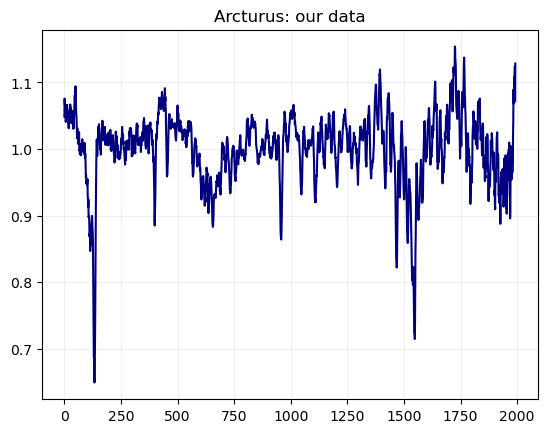

In [22]:
dat = np.loadtxt("flatlined/Flatlined_Arcturus.txt", comments="#")
print(f"data shape: {dat.shape}")

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat,color="navy", label="Vega spectrum")
frame.set_title("Arcturus: our data")
frame.grid(alpha=0.2)
show()
close(fig)


In [23]:
x_range = np.arange(1, dat.size+1)
dat_smooth=dat

# fitting the 1st peak
beta, pcov1 = curve_fit(f_gaussian, x_range[250:600], dat_smooth[250:600], p0=(-1, 450, 5, 1)) 
#order of parameters: amp, mu, sigma, zero

print(beta)
a1,m1,s1,z1=beta


[7.05701787e-02 4.31438233e+02 1.08953803e+01 1.01339429e+00]


In [24]:
# fitting the second peak
beta, pcov5 = curve_fit(f_gaussian, x_range, dat_smooth, p0=(-0.4, 1900, 50, 1.1))
a5,m5,s5,z5=beta
z = np.mean([z1,z5])

f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a5,m5,s5,0)


In [25]:
def f_superb(x,a1,m1,s1, a5,m5,s5, a,b,z):
    """Returns a combination of 2 Gaussians plotted on an exponential"""
    gaussian1 = a1 * np.exp(-(x - m1) ** 2 / (2.0 * s1 ** 2))
    gaussian2 = a5 * np.exp(-(x - m5) ** 2 / (2.0 * s5 ** 2))
    exponential = a * np.exp(b * x) + z
    return gaussian1 + gaussian2 + exponential

# fitting data to an exponential to obtain a baseline
beta, pcov_exp = curve_fit(f_exp,x_range,dat_smooth,p0=(1,0.0001,1))
print(beta)
exp_a,exp_b,exp_z = beta

[ 2.51432141e+00 -3.57580449e-07 -1.51363725e+00]


In [26]:
D1=np.array([a1,m1,s1])
D12=np.array([a5,m5,s5])
D_exp=np.array([exp_a,exp_b,1])

# fitting again to the superb function

beta,pcov =curve_fit(f_superb, x_range, dat_smooth, p0=np.concatenate([D1, D12, D_exp]))
np.concatenate([D1, D12, D_exp])
a1,m1,s1,a5,m5,s5,a,b,z=beta
print(beta)



[ 8.81534930e-02  4.31920901e+02  1.29119335e+01 -6.39733126e-02
  1.92994369e+03  2.84956704e+01 -8.81082963e+01 -8.98569583e-08
  8.91010230e+01]


In [27]:
# a function for multiple exponentials

def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on an exponential"""
    num_gaussians = (len(params) - 3) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    # exponential part
    exp_a, exp_b, exp_z = params[-3:]
    y += exp_a * np.exp(exp_b * x) + exp_z
    return y

# doing a new fit, combining the 2 peaks with the exponential fit
initial_gaussians = [D1, D12] # more will be added as needed
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z] # flattening the initial guesses for curve_fit

beta, pcov = curve_fit(f_superior, x_range, dat_smooth, p0=initial_guess)

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]
print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

Gaussian parameters: [[ 8.81769773e-02  4.31922462e+02  1.29162923e+01]
 [-6.40321592e-02  1.92991990e+03  2.85447133e+01]]
Exponential parameters: [6.64483044e-01 1.18562327e-05 3.28224458e-01]


In [28]:
# Initial guesses for the peak positions
D1=np.array([-0.3,170,20])
D2=np.array([-0.2,400,5]) #Na I
D3 = np.array([-0.1,950,10]) 
D4 = np.array([-0.15,1550,10]) #Fe I
D5 = np.array([-0.3,1750,10])

initial_gaussians = [D1,D2,D3,D4,D5]
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z]

a_in_pix=-1.217
a_off = 7060

x_range_a = a_in_pix*x_range + a_off

# doing a fit for the 5 chosen pix on an exponential
beta, pcov = curve_fit(f_superior, x_range_a, dat_smooth, p0=initial_guess)
print("Parameters:", beta) 

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]

# poor attempt at error analysis
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)


Parameters: [-3.00000000e-01  1.70000000e+02  2.00000000e+01 -2.00000000e-01
  4.00000000e+02  5.00000000e+00 -1.00000000e-01  9.50000000e+02
  1.00000000e+01 -1.50000000e-01  1.55000000e+03  1.00000000e+01
 -3.00000000e-01  1.75000000e+03  1.00000000e+01  2.12826443e+00
  3.46319292e-07 -1.13279119e+00]
Gaussian parameters: [[-3.00e-01  1.70e+02  2.00e+01]
 [-2.00e-01  4.00e+02  5.00e+00]
 [-1.00e-01  9.50e+02  1.00e+01]
 [-1.50e-01  1.55e+03  1.00e+01]
 [-3.00e-01  1.75e+03  1.00e+01]]
Exponential parameters: [ 2.12826443e+00  3.46319292e-07 -1.13279119e+00]


[47.0964009  11.77410023 23.54820045 23.54820045 23.54820045]
Oxygen peak equivalent width: 47.09640090061899
H-alpha peak equivalent width: 11.774100225154747
Na I peak equivalent width: 23.548200450309494
Mg I peak equivalent width: 23.548200450309494
H-beta peak equivalent width: 23.548200450309494
Error in FWHMs: inf


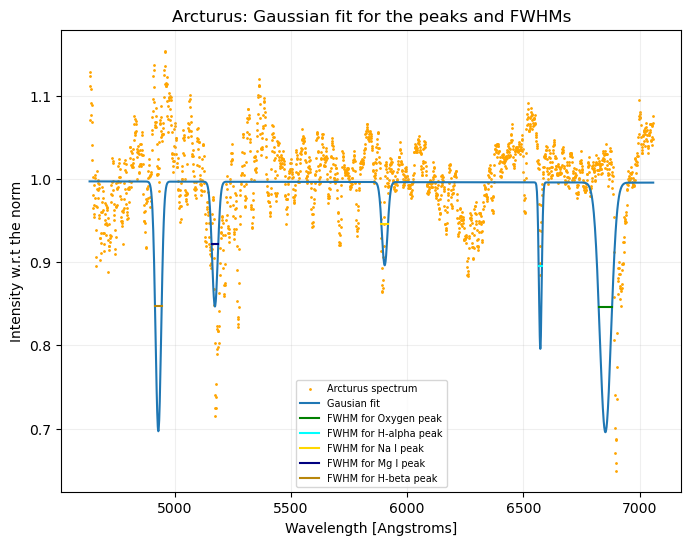

In [29]:
  
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

PeakDescriptions=["Oxygen", "H-alpha", "Na I", "Mg I", "H-beta"]
c=0
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

a_in_pix=-1.217
a_off = 7060

x_range_a = a_in_pix*x_range + a_off

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,dat_smooth, color="orange", label="Arcturus spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range, *beta), label="Gausian fit")

p=0
PeakColors=["green", "cyan","gold","navy","darkgoldenrod"]
PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m*a_in_pix+a_off)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))
    
    # getting the exponential fit data to know the y-coordinates of FWHM plot
    exp_a,exp_b,exp_z=exp_params
    z=f_exp(m,exp_a,exp_b,exp_z)    
    
    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(a_in_pix*fwhm_x + a_off,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1
    
frame.set_title("Arcturus: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)


Filename: miles spectra/arcturus_miles.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   

data shape: (1, 4367)
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4367 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT ----------------------------------------------------------------------  COMMENT ************************** REDUCEME HEADER ***************************  COMMENT ----------------------------------------------------------------------  HISTOR

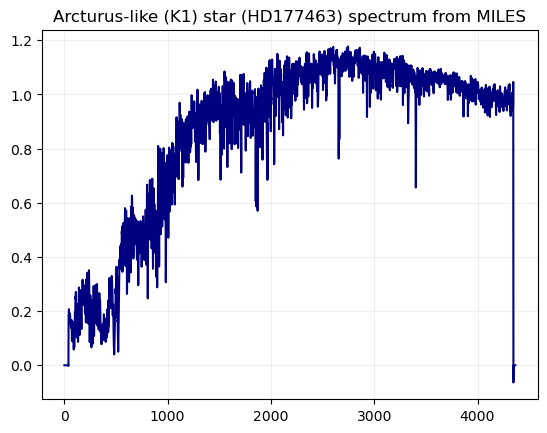

In [30]:
# getting the MILES ccomparison spectrum for Arcturus
#

hdulist = fits.open('miles spectra/arcturus_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
arcturus_miles = dat[0,:]
print(hdr)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(arcturus_miles,color="navy", label="Vega spectrum")
frame.set_title("Arcturus-like (K1) star (HD177463) spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

In [31]:
dat_arcturus = arcturus_miles[1000:4000] # choosing a relevant section of the data

In [32]:
x_range = np.arange(0, np.size(arcturus_miles[1000:4000]))
x_range_miles = x_range*0.9+3500+1000 # using the pixel -> Angstrom conversion values provided in the header, and accounting for cropping the data

[-4.55646407e+03 -2.09616848e-03  1.07816823e+00]


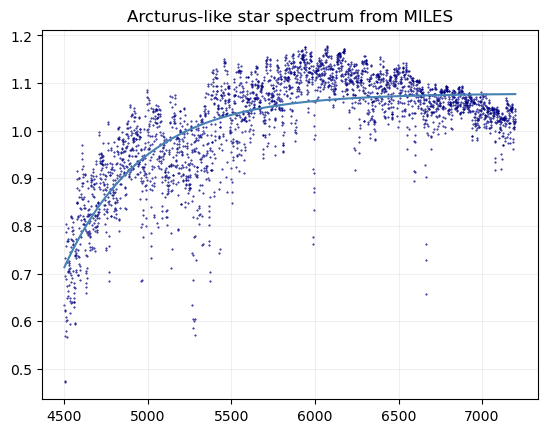

In [33]:
def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

beta, pcov = curve_fit(f_exp, x_range_miles, dat_arcturus, p0=[2,-0.001,0.4])

print(beta)
exp_a,exp_b,exp_z = beta

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,dat_arcturus,color="navy", label="Arcturus spectrum", s=0.2) # the section of the data that seems relevant
frame.plot(x_range_miles, f_exp(x_range_miles,exp_a,exp_b,exp_z), color="steelblue", label='Fitted Exponential Curve')
frame.set_title("Arcturus-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

In [34]:
arcturus_miles_line=dat_arcturus-f_exp(x_range_miles,exp_a,exp_b,exp_z)

[array([-4.e-01,  6.e+03,  5.e+00]), array([-5.00e-01,  6.65e+03,  5.00e+00])]
Parameters: [-3.20035759e-01  5.99014700e+03  1.15437749e+00 -4.12922249e-01
  6.66277068e+03  1.30464341e+00 -5.17442560e-06  3.11111065e-02]
Gaussian parameters: [[-3.20035759e-01  5.99014700e+03  1.15437749e+00]
 [-4.12922249e-01  6.66277068e+03  1.30464341e+00]]
Line parameters: [-5.17442560e-06  3.11111065e-02]


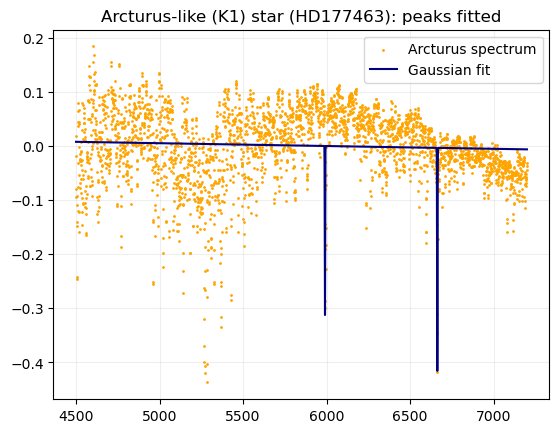

In [35]:
def f_superior_line(x, *params):
    """Returns a combination of multiple Gaussians plotted on a straight line"""
    num_gaussians = (len(params)-2) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    # exponential part
    a,b = params[-2:]
    y += a*x+b
    return y

# using the parameters for the fit from our data, hence, redefining them in angstroms

gaussian_params_a=np.zeros(np.shape(gaussian_params))

p=0
for Peak in gaussian_params:
    a,m,s=Peak
    gaussian_params_a[p,0]=a
    gaussian_params_a[p,1]=m*a_in_pix+a_off
    gaussian_params_a[p,2]=s*a_in_pix
    p+=1
    
# had to fit them manually anyways due to the large discrepancy between our data and MILES

D1=np.array([-0.4,5300,1])
D8=np.array([-0.4,6000,5]) #Na I
D9 = np.array([-0.3,6300,5]) #?
D11 = np.array([-0.5,6650,5]) #Fe I

initial_gaussians = [D8,D11]
print(initial_gaussians)
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [-0.00001,0]

beta, pcov = curve_fit(f_superior_line, x_range_miles, arcturus_miles_line, p0=initial_guess)
print("Parameters:", beta) 

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
line_params = beta[num_gaussians * 3:]

# poor attempt at error analysis
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Line parameters:", line_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_miles, arcturus_miles_line, color="orange", label="Arcturus spectrum", s=1)
frame.plot(x_range_miles, f_superior_line(x_range_miles, *beta), color="navy", label="Gaussian fit")
frame.set_title("Arcturus-like (K1) star (HD177463): peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[2.71835125 3.07220044]
Na I peak equivalent width: 2.7183512468578566
H-alpha peak equivalent width: 3.0722004425467637
Error in FWHMs: 0.5294660169101968


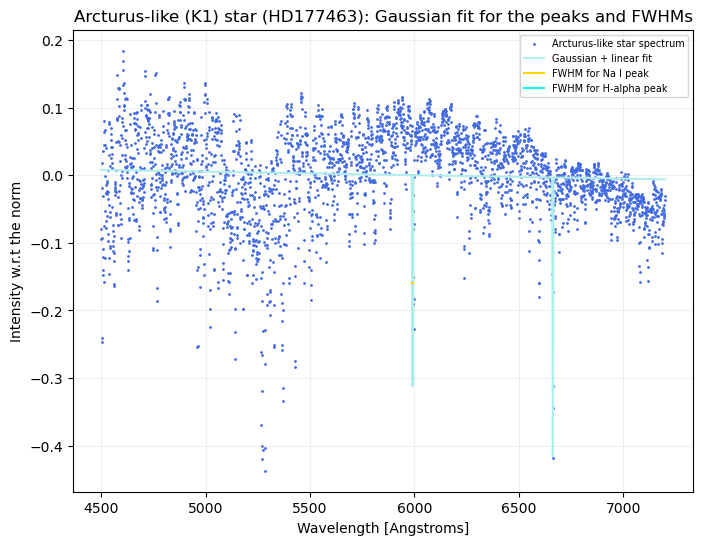

In [36]:
def f_line(x,a,b):
    """returns a straight line equation of the form ax+b"""
    return a*x+b

FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
PeakDescriptions=["Na I", "H-alpha"]
PeakColors=["gold","cyan"]
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,arcturus_miles_line, color="royalblue", label="Arcturus-like star spectrum",s=1)
frame.plot(x_range_miles,f_superior_line(x_range_miles, *beta),color="paleturquoise", label="Gaussian + linear fit")

p=0

PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))

    # getting the exponential fit data to know the y-coordinates of FWHM plot
    l_a,l_b=line_params
    z=f_line(m,l_a,l_b)

    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(fwhm_x,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1

frame.set_title("Arcturus-like (K1) star (HD177463): Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)